In [240]:
#Importing the necessary requirement
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters
import seaborn as sns
%matplotlib inline
import tensorflow as tf


#importing the requirements needed for the data analysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import callbacks
from scipy.stats import ttest_ind

In [195]:
#loading the csvfile into pandas dataframe
df = pd.read_csv('ancona_data.csv', parse_dates=['Date'])
df_with_O3 = df[~((df['O3'].isna()) | (df['O3'] == 0))]
df_with_O3 = df_with_O3.reset_index(drop=True)

#defining the inputs and outputs
df_with_O3_features = df_with_O3.copy()
df_with_O3_features['Date'] = (pd.to_datetime(df_with_O3_features['Date']) - pd.Timestamp('1970-01-01')) / pd.Timedelta('1D')
X = df_with_O3_features.copy()
y = X.pop('O3')

#cleaning the missing values
Imputer = SimpleImputer()
null_values = ['NO2',  'PM10', 'PM2.5']
X[null_values] = pd.DataFrame(Imputer.fit_transform(X[null_values])) 

In [196]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392821 entries, 0 to 392820
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Date                 392821 non-null  float64
 1   NO2                  392821 non-null  float64
 2   PM10                 392821 non-null  float64
 3   PM2.5                392821 non-null  float64
 4   Latitude             392821 non-null  float64
 5   Longitude            392821 non-null  float64
 6   station_name         392821 non-null  object 
 7   Wind-Speed (U)       392821 non-null  float64
 8   Wind-Speed (V)       392821 non-null  float64
 9   Dewpoint Temp        392821 non-null  float64
 10  Soil Temp            392821 non-null  float64
 11  Total Percipitation  392821 non-null  float64
 12  Vegitation (High)    392821 non-null  float64
 13  Vegitation (Low)     392821 non-null  float64
 14  Temp                 392821 non-null  float64
 15  Relative Humidity

In [168]:
X.describe()

,Date,NO2,PM10,PM2.5,Latitude,Longitude,Wind-Speed (U),Wind-Speed (V),Dewpoint Temp,Soil Temp,Total Percipitation,Vegitation (High),Vegitation (Low),Temp,Relative Humidity,id
count,392821.000000,392821.000000,392821.000000,392821.000000,392821.000000,392821.000000,392821.000000,392821.000000,392821.000000,392821.000000,3.928210e+05,392821.000000,392821.000000,392821.000000,392821.000000,392821.00000
mean,19266.873253,12.291497,18.694320,12.943337,43.568967,13.367965,-0.111920,-0.203184,50.184321,55.315780,1.646040e-03,3.059494,2.777382,55.227406,75.308758,35.24249
std,228.256579,8.783412,9.934027,7.408584,0.076386,0.128153,0.889658,0.956522,17.810482,18.173177,4.936355e-03,0.248082,0.147384,18.208184,18.543084,13.41493
min,18871.041667,0.000000,0.000000,0.000000,43.450000,13.150000,-3.877032,-3.671453,8.371775,12.047776,-6.940000e-18,2.718726,2.573985,10.109338,12.943158,22.00000
25%,19069.166667,6.285742,12.000000,8.000000,43.550000,13.250000,-0.735505,-0.995726,48.855748,52.019315,2.358580e-07,2.810968,2.628872,51.998541,62.301633,28.00000
50%,19267.166667,10.110440,17.000000,11.955444,43.599523,13.372120,-0.368686,-0.359573,56.978183,59.735240,1.283123e-05,3.057545,2.776165,60.119940,79.915413,33.00000
75%,19464.333333,15.626753,22.749872,15.606927,43.637500,13.450000,0.456520,0.529874,62.158225,66.947629,6.131244e-04,3.271532,2.902693,66.981119,90.887015,38.00000
max,19661.958333,285.000000,249.000000,200.000000,43.650000,13.550000,3.617407,4.307326,72.999793,90.073126,7.496383e-02,3.470822,3.022056,88.419472,99.996023,90.00000


In [169]:
X.shape

(392821, 18)

In [170]:
y.min()

0.99999696

In [171]:
y

0         53.000000
1         49.232338
2         51.336113
3         39.351303
4         57.373196
            ...    
392816    47.104100
392817    48.762394
392818    24.000000
392819    57.000000
392820    50.228462
Name: O3, Length: 392821, dtype: float64

In [172]:
# encoding the categorical data and standardizing the data
features_num = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
features_cat = [cname for cname in X.columns if X[cname].dtype == "object"]

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

y = np.log(y)

#spliting the dataset into a trainig data and a validation data
train, test, train_y, test_y = train_test_split(X, y, random_state=0)

train = preprocessor.fit_transform(train)
test = preprocessor.transform(test)


input_shape = [train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [58]


In [173]:
y 

0         3.970292
1         3.896551
2         3.938394
3         3.672529
4         4.049577
            ...   
392816    3.852360
392817    3.886959
392818    3.178054
392819    4.043051
392820    3.916582
Name: O3, Length: 392821, dtype: float64

In [174]:
y_adjusted = np.exp(y)
y_adjusted

0         53.000000
1         49.232338
2         51.336113
3         39.351303
4         57.373196
            ...    
392816    47.104100
392817    48.762394
392818    24.000000
392819    57.000000
392820    50.228462
Name: O3, Length: 392821, dtype: float64

In [175]:
train_exp = pd.DataFrame(train[:10,:]).head()
train_exp.describe()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.000000,5.0
mean,-0.545407,-0.051401,0.866881,0.927258,-0.316720,-0.541767,0.208377,0.329117,0.063372,0.188918,...,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0
std,1.349630,1.056437,1.212065,1.787830,1.230264,0.765362,1.045263,0.635438,1.065735,0.975803,...,0.447214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.447214,0.0
min,-1.699022,-1.052467,-0.674353,-0.700908,-1.557526,-1.699509,-1.168425,-0.631618,-1.826512,-1.461203,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
25%,-1.422335,-0.601185,0.311291,-0.000363,-1.557526,-0.919945,-0.259990,0.009068,0.310493,0.179683,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
50%,-1.382548,-0.280952,0.842457,0.272968,-0.248399,-0.140381,0.141817,0.589069,0.557447,0.504712,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
75%,0.456249,-0.033620,1.241253,1.173337,0.719124,-0.140381,0.704043,0.816482,0.580364,0.656398,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
max,1.320620,1.711219,2.613757,3.891256,1.060728,0.191381,1.624439,0.862582,0.695068,1.065000,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0


In [70]:
train.shape

(294615, 58)

In [176]:
test.shape

(98206, 58)

In [188]:
#building the model
# Create a network 
model = keras.Sequential([
    # input layer
    layers.Dense(units=512, activation='relu', input_shape=input_shape),
    #hidden layers
    layers.Dense(units=512, activation='relu'),
    layers.Dense(units=128, activation='relu'),
    #output layers
    layers.Dense(units=1),
])

#defining stochastic gradient descent optimizer and loss function
model.compile(
    optimizer="adam",
    loss="mae",
)

#add a early stopping rate callback to prevent overfitting and underfitting
early_stopping = EarlyStopping(
    min_delta=0.001, 
    patience=5,
    restore_best_weights=True,
)

In [189]:
model

In [190]:
#training the model
history = model.fit(
    train, train_y, 
    validation_data=(test, test_y), 
    batch_size=5000, 
    epochs=500, 
    callbacks=[early_stopping])

Epoch 1/500
59/59 [==============================] - 54s 861ms/step - loss: 0.7154 - val_loss: 0.3538
Epoch 2/500
59/59 [==============================] - 48s 818ms/step - loss: 0.2927 - val_loss: 0.2458
Epoch 3/500
59/59 [==============================] - 49s 828ms/step - loss: 0.2272 - val_loss: 0.2162
Epoch 4/500
59/59 [==============================] - 46s 787ms/step - loss: 0.2129 - val_loss: 0.2114
Epoch 5/500
59/59 [==============================] - 44s 747ms/step - loss: 0.2079 - val_loss: 0.2040
Epoch 6/500
59/59 [==============================] - 44s 746ms/step - loss: 0.2020 - val_loss: 0.2000
Epoch 7/500
59/59 [==============================] - 44s 748ms/step - loss: 0.2020 - val_loss: 0.2046
Epoch 8/500
59/59 [==============================] - 45s 767ms/step - loss: 0.1972 - val_loss: 0.1962
Epoch 9/500
59/59 [==============================] - 44s 739ms/step - loss: 0.1940 - val_loss: 0.1953
Epoch 10/500
59/59 [==============================] - 43s 737ms/step - loss: 0.191

Minimum Validation Loss: 0.1692


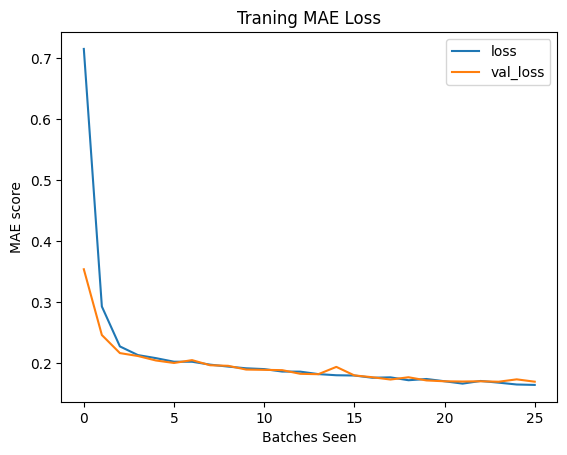

In [191]:
# plotting the learning curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));
plt.title('Traning MAE Loss')
plt.xlabel('Batches Seen')
plt.ylabel('MAE score')
fig = plt.gcf()
fig.savefig('Traning MAE Loss')
plt.show()

In [192]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 512)               30208     
                                                                 
 dense_51 (Dense)            (None, 512)               262656    
                                                                 
 dense_52 (Dense)            (None, 128)               65664     
                                                                 
 dense_53 (Dense)            (None, 1)                 129       
                                                                 
Total params: 358657 (1.37 MB)
Trainable params: 358657 (1.37 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [193]:
model.optimizer.learning_rate

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>

In [194]:
Weights_bias = model.weights

In [199]:
result = model.predict(test)

3069/3069 [==============================] - 110s 35ms/step


In [268]:
print('standardize result:', result)
result_adjusted = np.exp(result)
result_adjusted_list = tf.reshape(result_adjusted, [98206,])
result_adjusted_list = result_adjusted_list.numpy()
result_adjusted_list = pd.Series(result_adjusted_list, name='predicted O3')
print('Predicted o3:', result_adjusted_list)

standardize result: [[4.2655067]
 [4.249335 ]
 [3.2661831]
 ...
 [3.9375892]
 [2.7810383]
 [4.0290213]]
Predicted o3: 0        71.200989
1        70.058792
2        26.211103
3        59.976490
4        59.376331
           ...    
98201    91.574318
98202    42.608406
98203    51.294788
98204    16.135765
98205    56.205875
Name: predicted O3, Length: 98206, dtype: float32


In [269]:
print('standardize actual:', test_y)
test_y_adjusted = np.exp(test_y)
test_y_adjusted = test_y_adjusted.reset_index(drop=True)
print('\nO3 actual:', test_y_adjusted)

standardize actual: 116933    4.218762
366776    4.531529
150039    3.784190
314138    3.943737
326457    4.406098
            ...   
158048    4.499810
156562    3.555348
193380    4.185332
234558    2.946317
128533    3.982373
Name: O3, Length: 98206, dtype: float64

O3 actual: 0        67.949295
1        92.900480
2        44.000000
3        51.611090
4        81.949040
           ...    
98201    90.000000
98202    35.000000
98203    65.715294
98204    19.035725
98205    53.644184
Name: O3, Length: 98206, dtype: float64


In [270]:
# statistical significance
t_stat, p_value = ttest_ind(test_y_adjusted, result_adjusted_list)
print(f'T-statistic: {t_stat}, p-value: {p_value}')


# Calculating R²
r2 = r2_score(test_y_adjusted, result_adjusted_list)
print('R-Squared (R²):', r2)

# Calculating RMSE
rmse = np.sqrt(mean_squared_error(test_y_adjusted, result_adjusted_list))
print('Root Mean Squared Error (RMSE):', rmse)

T-statistic: 8.694095943248874, p-value: 3.522205699287786e-18
R-Squared (R²): 0.8413604553589491
Root Mean Squared Error (RMSE): 10.339864650174375


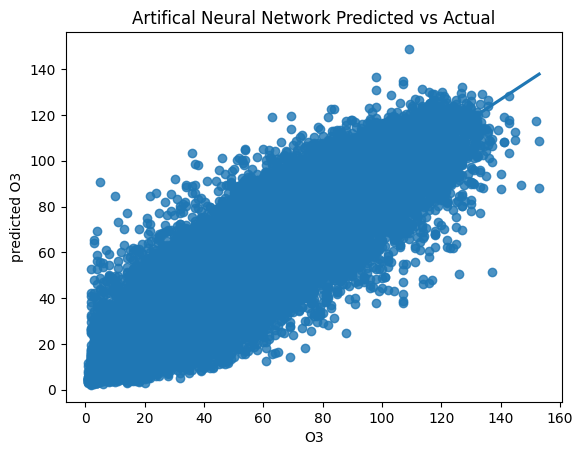

In [275]:
sns.regplot(x=test_y_adjusted, y=result_adjusted_list )
plt.title('Artifical Neural Network Predicted vs Actual')
fig3 = plt.gcf()
fig3.savefig('ANN_pred_act.png')
plt.show()

In [279]:
output = pd.concat([test_y_adjusted, result_adjusted_list], axis=1)
output.to_csv('ANN.pred.csv')